# Imports

In [1]:
import os

import pandas as pd

from models import get_all_models, make_model
from utils.loss import loss
from utils.misc import filter_gedi, get_device, seed_everyting
from utils.models import test
from utils.pipeline import get_data
from utils.plots import (
    compare_predictions,
    plot_gedi_distribution,
    plot_image_and_prediction,
    plot_image_channels,
    plot_labels_in_germany,
    plot_predictions,
    plot_true_vs_predicted_histogram,
    plot_true_vs_predicted_scatter,
)
from utils.predictions import predict_batch, predict_image

# Global parameters

In [2]:
image_size = 256
img_dir = "data/images"
weights_dir = "weights"
patch_dir = "data/patches"
results_dir = "results"
gedi_dir = "data/gedi"
random_state = 42
batch_size = 8
num_workers = os.cpu_count() // 4
bins = list(range(0, 55, 5))
device = get_device()

seed_everyting(random_state)

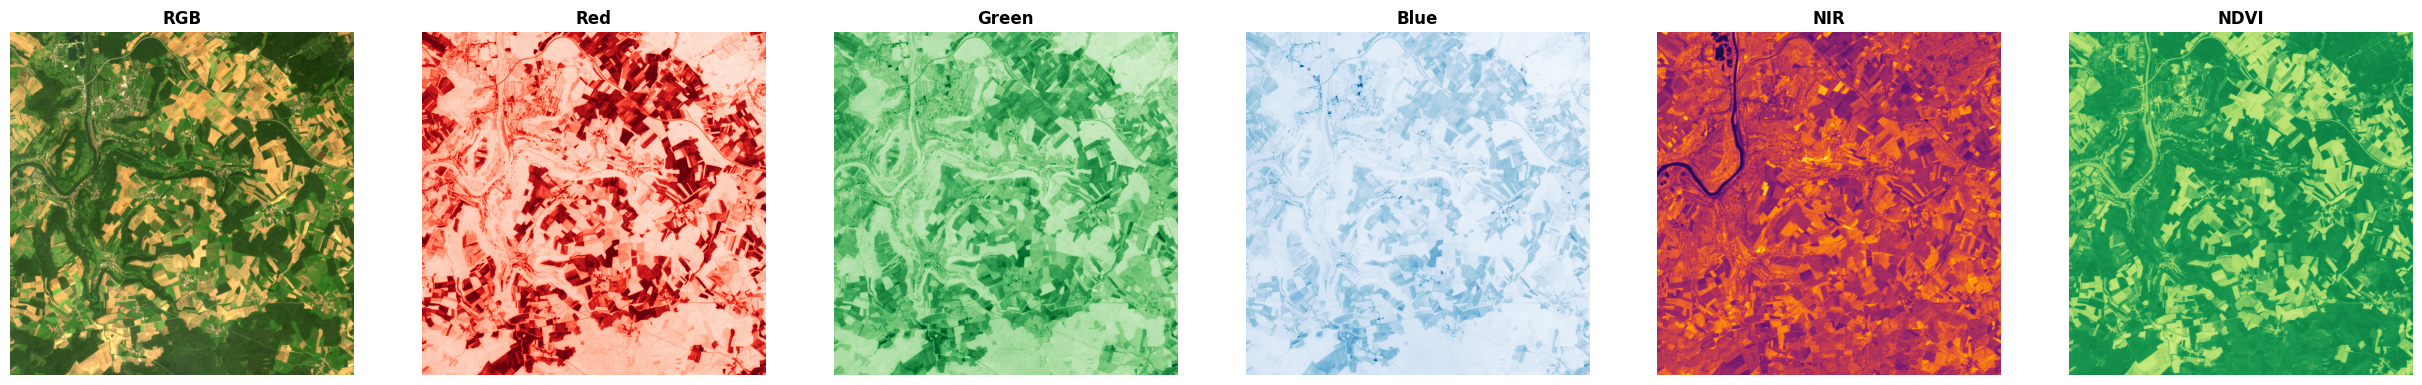

In [3]:
plot_image_channels(f"{img_dir}/L15-1060E-1348N.tif")

In [4]:
# plot_labels_in_germany()

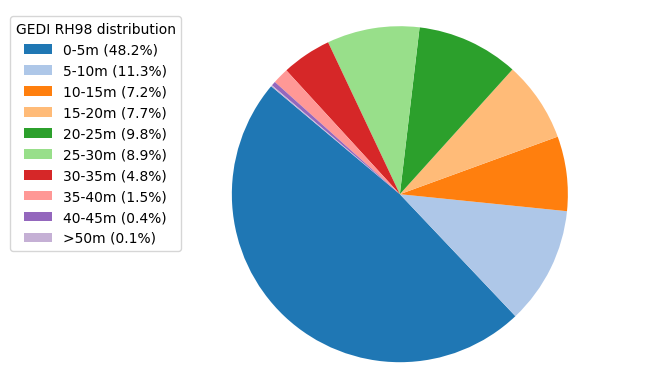

0.1997512076287365

In [10]:
gedi = pd.read_feather("data/gedi/gedi_complete.fth")

filtered_gedi = filter_gedi(gedi)
plot_gedi_distribution(filtered_gedi.rh98)

len(filtered_gedi) / len(gedi)

# Create dataloaders

In [6]:
# Create dataloaders
_, _, test_dl = get_data(
    img_dir, patch_dir, gedi_dir, image_size, batch_size, num_workers, bins
)

2023-11-24 13:44:43,514 Starting preprocessing...
2023-11-24 13:44:43,515 Directories validated.
2023-11-24 13:44:43,517 Images loaded.
2023-11-24 13:44:43,517 Number of images: 49
2023-11-24 13:44:53,133 GEDI data loaded.
2023-11-24 13:44:53,166 Loaded existing patch info file. Skipping image processing.
2023-11-24 13:44:53,166 Number of patches: 26690
2023-11-24 13:44:53,167 Number of labels: 2012084


# Load models

In [7]:
models = {
    name: make_model(name).load(os.path.join(weights_dir, f"{name}.pt")).to(device)
    for name in get_all_models()
    if os.path.exists(os.path.join(weights_dir, f"{name}.pt"))
}

# Visualise results

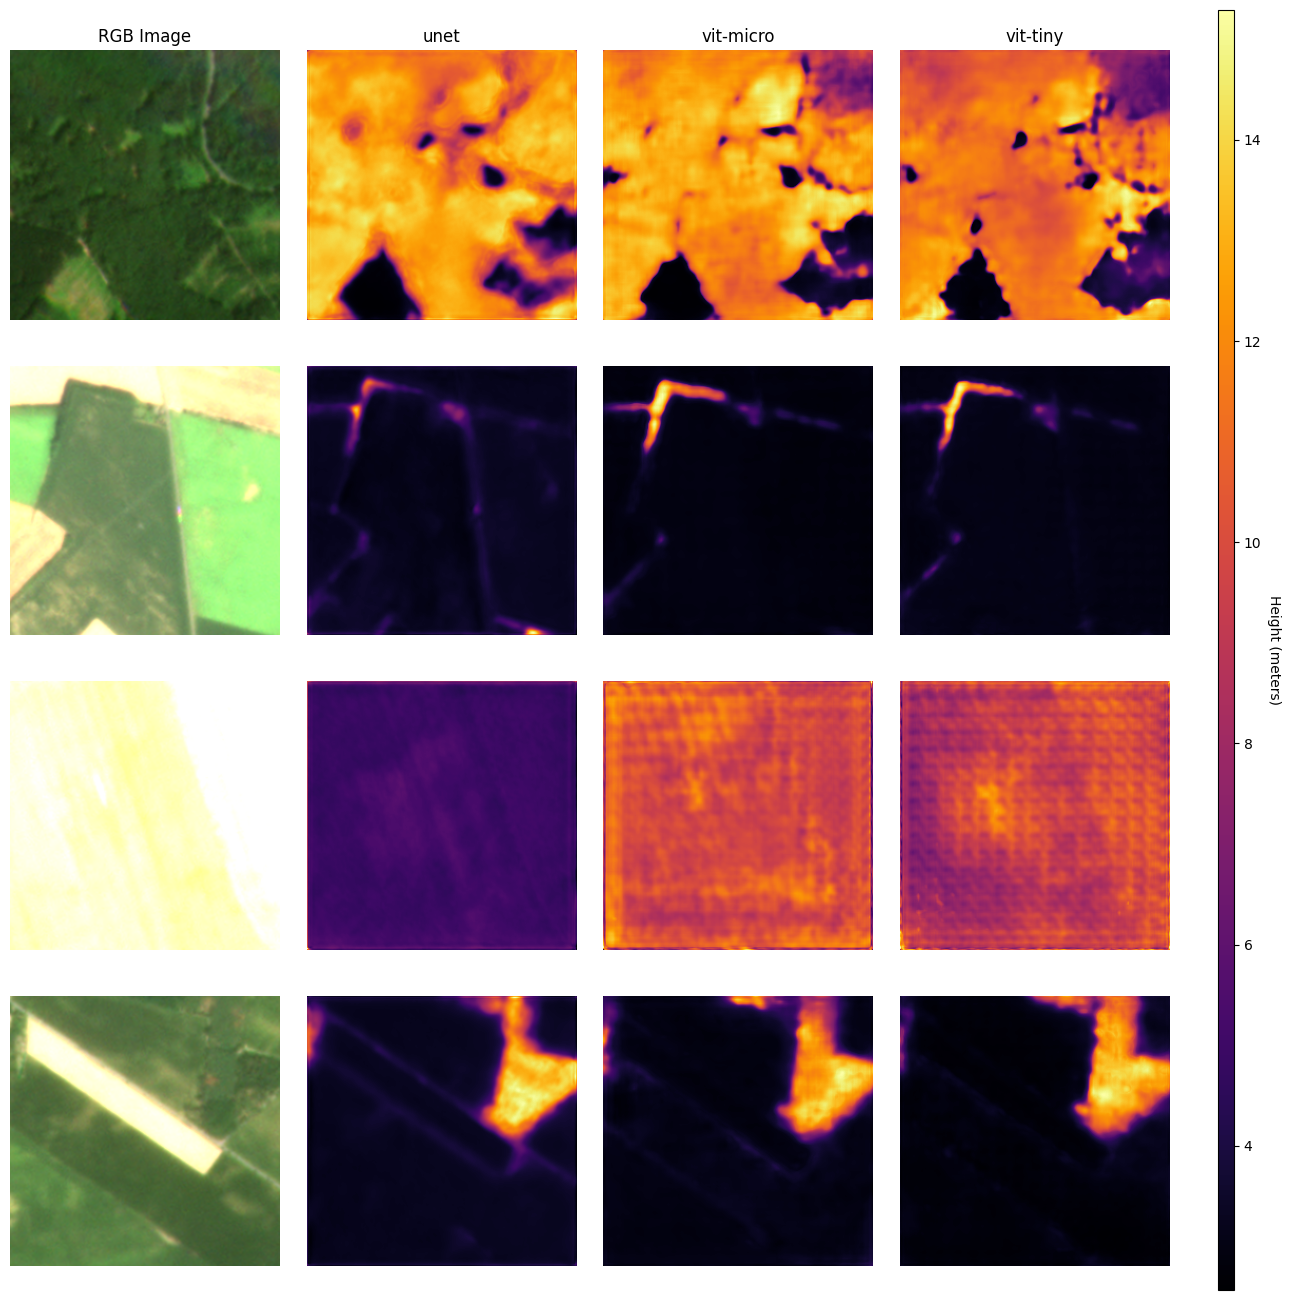

In [8]:
plot_predictions(*predict_batch(models, test_dl, device))

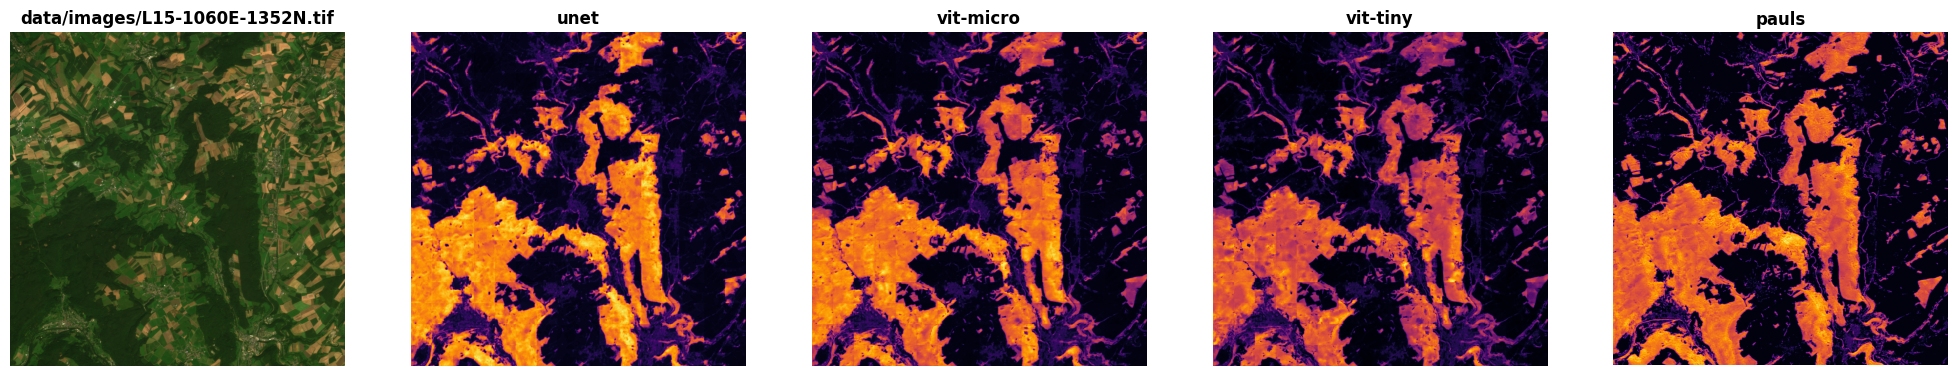

In [13]:
img = os.path.join(img_dir, "L15-1060E-1352N.tif")
predictions = {
    name: predict_image(img, model, device, image_size)[-1]
    for (name, model) in models.items()
}

predictions["pauls"] = "../../Downloads/prediction_result_shifted_new.tif"

compare_predictions(img, predictions)

# Evaulate model

In [10]:
model_name = "unet"
model = models[model_name]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]loc("mps_not_equal"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":253:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W1048576 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W1048576 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
Testing:  99%|█████████▊| 75/76 [01:06<00:00,  1.13i

Final test loss: 2.281744
Final MAE loss: 3.239870
Final RMSE loss: 5.431022
Ranges: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
Losses by range: [ 1.2257516  3.4741561  4.136072   3.5682342  2.4784882  3.7887573
  7.614421   9.982073  10.41152    6.703505 ]


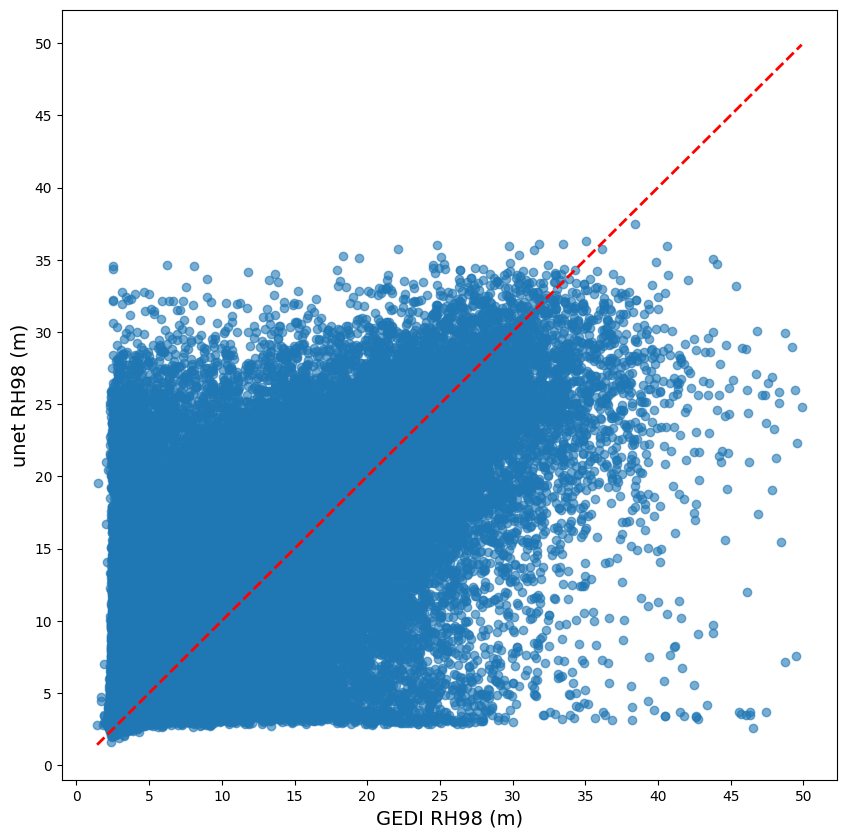

In [11]:
metrics = test(model, test_dl, loss, device, bins)

print(
    f"Final test loss: {metrics.get('total'):>8f}\n"
    f"Final MAE loss: {metrics.get('mae'):>8f}\n"
    f"Final RMSE loss: {metrics.get('rmse'):>8f}\n"
    f"Ranges: {bins}\n"
    f"Losses by range: {metrics.get('loss_by_range')}"
)

plot_true_vs_predicted_scatter(
    metrics.get("targets"),
    metrics.get("predicted"),
    model_name,
)

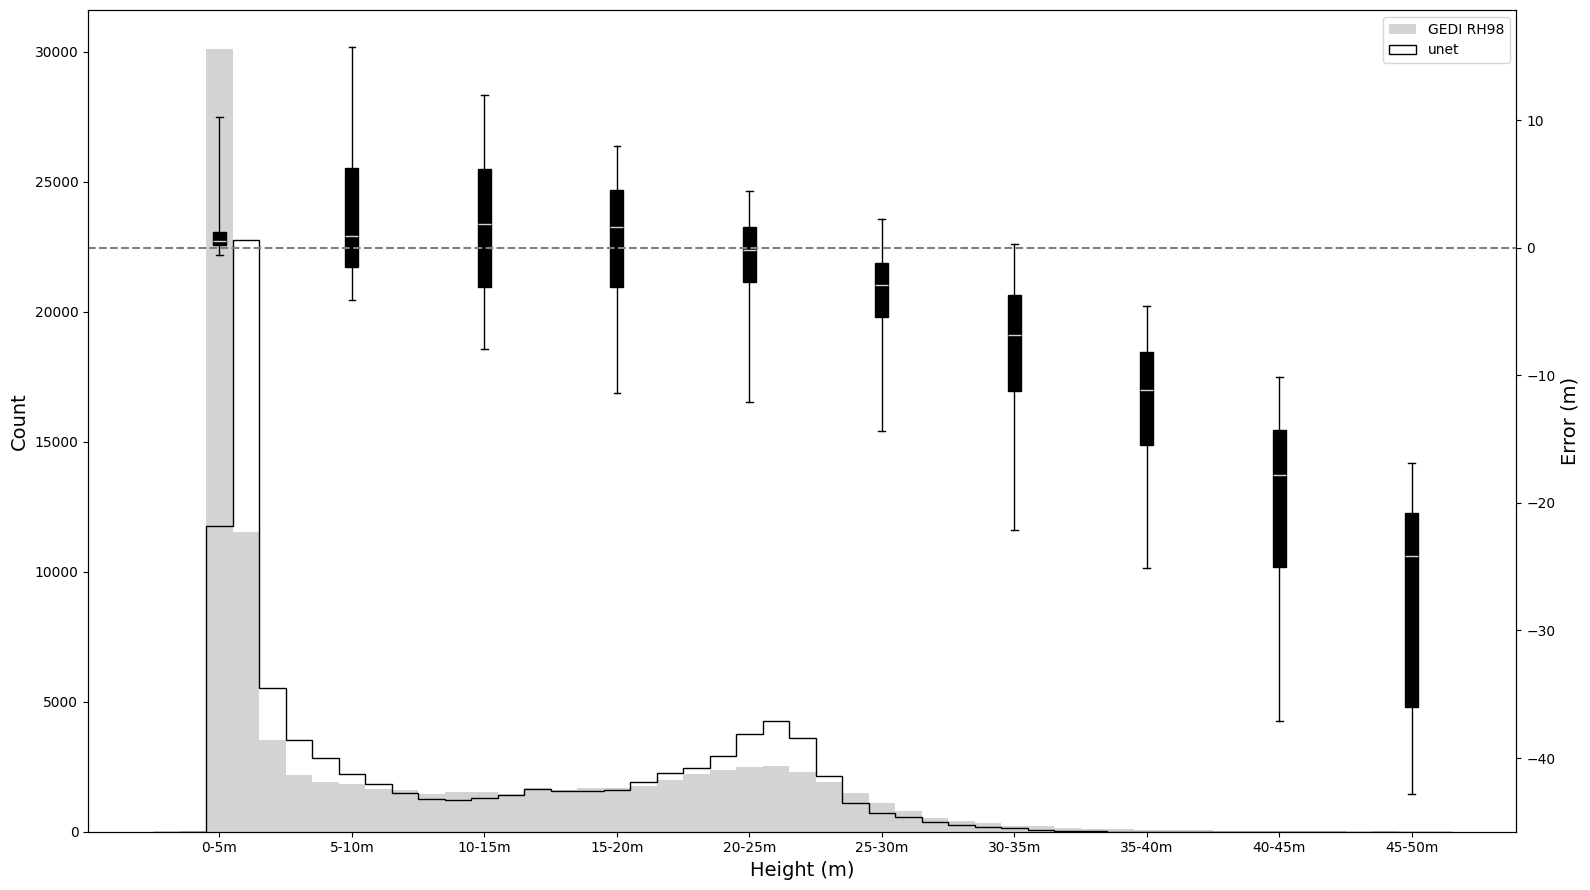

In [12]:
plot_true_vs_predicted_histogram(
    metrics.get("targets"),
    metrics.get("predicted"),
    model_name,
)